## Комментарии к коду



1.   Словарь --  МАС
2.   Датасет -- сокращенный Lenta.ru (взяла его, так как там содержатся тексты из оченб разных доменов: происшествия, культура, медицина, спорт, политика и тд.)
3. Далее вы увидите раздел "Дособираю данные". Изначально в списке моих многозначных лексем присутствовало слово *игла*, которое при разметке в большинстве случаев оказалось именем собственным для оружия или частью топонима --> его при разметке учитывать было нельзя, и чтобы не пересобирать датасет я добавила слово *мера*. Если запустить все ячейки последовательно, то получится необходимый датасет.



In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
!pip install tensorflow Cython matplotlib simple-elmo

In [ ]:
!pip install git+https://github.com/lopuhin/python-adagram.git

In [ ]:
!pip install pymorphy2

In [24]:
! gunzip /content/lenta-ru-news.csv.gz

In [4]:
import adagram
from simple_elmo import ElmoModel

# обработка данных и ML
import pandas as pd
import nltk
from lxml import html
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from tqdm.notebook import tqdm
from tqdm import trange
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.cluster import *
from collections import Counter
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

morph = MorphAnalyzer()
token = RegexpTokenizer('\w+')
stops = set(stopwords.words('russian'))

def normalize(text):
    words = [morph.parse(word)[0].normal_form for word in tokenize(text) if word]
    return words

def tokenize(text):
    return token.tokenize(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Подготовка датасета с контекстами

In [30]:
df = pd.read_csv('/content/lenta-ru-news.csv')

In [31]:
df = df.sample(frac=0.05)
df = df.dropna(subset=['text'])

In [32]:
df = df[['text', 'topic', 'tags']]

In [33]:
tqdm.pandas()

In [34]:
mystem = Mystem()
def lemmatized_context(s):
    return [w.lower() for w in mystem.lemmatize(" ".join(tokenize(s)))]

In [35]:
df['lemmatized'] = df['text'].progress_apply(lemmatized_context)

  0%|          | 0/36968 [00:00<?, ?it/s]

In [36]:
def get_alignment(lemmas):
  words = ['кисть', 'игла', 'ключ', 'игра', 'хвост', 'мера']
  for i in words:
    if i in lemmas:
      return i
  return False

In [37]:
df['aligned'] = df.lemmatized.apply(get_alignment)

In [38]:
def joiner(string):
  return ''.join(string)

In [39]:
target_df = df[df['aligned'] != False]

In [ ]:
target_df['lemmatized'] = target_df['lemmatized'].apply(lambda x: ''.join(x).strip('\n'))
target_df

In [53]:
target_df.to_csv('mas_contexts_1_fin.csv')

## Дезамбигуация контекстов и значений


In [6]:
!curl "https://s3.amazonaws.com/kostia.lopuhin/all.a010.p10.d300.w5.m100.nonorm.slim.joblib" > all.a010.p10.d300.w5.m100.nonorm.slim.joblib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1394M  100 1394M    0     0  55.6M      0  0:00:25  0:00:25 --:--:-- 52.2M


In [10]:
target_df = pd.read_csv('/content/mas_contexts_1_fin.csv')

In [7]:
vm = adagram.VectorModel.load('all.a010.p10.d300.w5.m100.nonorm.slim.joblib')

In [12]:
context_dict = target_df.groupby('aligned')['lemmatized'].apply(list).to_dict()

In [13]:
def disambiguate(model, word, context):
    word = lemmatized_context(word)[0]
    # context = ' '.join(context)
    probs = model.disambiguate(word, lemmatized_context(context))
    return 1 + probs.argmax()

In [14]:
target_df['predict_sense_id'] = [disambiguate(vm, word, context) for word, context in tqdm(zip(target_df['aligned'], target_df['text']), total=len(target_df))]

  0%|          | 0/4599 [00:00<?, ?it/s]

In [ ]:
target_df

In [15]:
pd.set_option('display.max_colwidth', 1000)

In [16]:
df_defs = pd.read_csv('/content/mas_definitions.csv')

In [17]:
df_defs['predict_sense_id'] = [disambiguate(vm, word, context) for word, context in tqdm(zip(df_defs['word'], df_defs['definition']), total=len(df_defs))]

  0%|          | 0/41 [00:00<?, ?it/s]

In [19]:
df_defs_no_dupes = df_defs.drop_duplicates(subset=['word','predict_sense_id'])

In [ ]:
data_ada = []
for i in df_defs_no_dupes.values.tolist():
  # print([i[0], i[2]])
  my_list = list(target_df[(target_df['aligned'] == i[0]) & (target_df['predict_sense_id'] == i[2])]['text'])[:5]
  print(len(my_list))
  for j in my_list:
    data_ada.append([i[0], i[2], j])

In [160]:
data_ada = pd.DataFrame(data_ada, columns=['word', 'label', 'context'])
data_ada.to_csv('stats_adagramm.csv')

## Дособираю данные

In [ ]:
mera_df = target_df[target_df['aligned'] == 'мера']
mera_df

In [27]:
mera_df['predict_sense_id'] = [disambiguate(vm, word, context) for word, context in tqdm(zip(mera_df['aligned'], mera_df['text']), total=len(mera_df))]

  0%|          | 0/2381 [00:00<?, ?it/s]

In [29]:
mera_df.to_csv('mas_contexts_1.csv', mode='a', header=False)

In [55]:
mera_df_new = mera_df.groupby(['aligned', 'predict_sense_id'])['text'].apply(lambda x: x[:5]).to_frame()

In [57]:
mera_df_new.to_csv('stats_adagramm.csv', mode='a', header=False)

In [34]:
def_mera = pd.read_csv('/content/mas_definitions_mera.csv')
def_mera['predict_sense_id'] = [disambiguate(vm, word, context) for word, context in tqdm(zip(def_mera['word'], def_mera['defintion']), total=len(def_mera))]

  0%|          | 0/6 [00:00<?, ?it/s]

In [59]:
def_mera = def_mera.rename(columns={"word": "word", "defintion": "definition", "predict_sense_id": "predict_sense_id"})
df_defs = df_defs.append(def_mera)

In [61]:
df_defs.to_csv('defs_preds.csv')

In [79]:
df_defs[(df_defs['definition'].str.contains('хвост')) | (df_defs['word'].isin(['кисть', 'игла', 'ключ', 'игра', 'мера']))]

39

## Accuracy AdaGramm


In [180]:
acc_df_filtered = pd.read_csv('/content/stats - adagramm_checked.csv')
trues = list(acc_df_filtered[acc_df_filtered.is_equivalent == 1]['is_equivalent'])
print(f'Accuracy for filtered(excluding meanings not detected on definitions): {len(trues)/len(acc_df_filtered)}')

Accuracy for filtered(excluding meanings not detected on definitions): 0.4


## ELMO + кластеры

In [ ]:
!wget http://vectors.nlpl.eu/repository/20/196.zip

In [5]:
model = ElmoModel()
model.load("196.zip")

'The model is now loaded.'

In [15]:
elmo_df = target_df.sample(frac=0.5)

In [6]:
def get_elmo_vectors(word, contexts, model, normalized=False):
    if normalized:
      tokens = [c.split() for c in contexts]
    else:
      tokens = [normalize(c) for c in contexts]
    all_vectors = model.get_elmo_vectors(tokens)
    word_vecs = []
    for i in trange(len(contexts)):
          word_vecs.append(all_vectors[i][tokens[i].index(word)])
    return word_vecs

In [7]:
elmo_dict = target_df.groupby(['aligned'])['lemmatized'].apply(lambda x: list(x)[:150]).to_dict()

In [32]:
elmo_dict_text = target_df.groupby(['aligned'])['text'].apply(lambda x: list(x)[:150]).to_dict()

In [10]:
import pickle
with open('elmo_dict.pickle', 'wb') as f:
     pickle.dump(elmo_dict, f)

In [ ]:
elmo_vectors = {}
for i in elmo_dict:
  X = get_elmo_vectors(i, elmo_dict[i], model, normalized=True)
  if i in elmo_vectors:
    elmo_vectors[i].append(X)
  else:
    elmo_vectors[i] = []
    elmo_vectors[i].append(X)

In [11]:
import pickle
with open('elmo_full.pickle', 'wb') as f:
     pickle.dump(elmo_vectors, f)

In [27]:
with open('elmo_full.pickle', 'rb') as f:
     elmo_vectors = pickle.load(f)

In [ ]:
df_defs_filtered = df_defs[(df_defs['definition'].str.contains('хвост')) | (df_defs['word'].isin(['кисть', 'игла', 'ключ', 'игра', 'мера']))]
def_dict = df_defs_filtered.groupby(['word'])['definition'].apply(lambda x: list(x)).to_dict()
def_vectors = {}
for i in def_dict:
  print(len(def_dict[i]))
  X = np.array(get_elmo_vectors(i, def_dict[i], model))
  print(X.shape)
  def_vectors[i] = np.zeros((X.shape[0], 1024))
  def_vectors[i] += X

In [66]:
from sklearn.cluster import AffinityPropagation

elmo_labels = {}
def_labels = {}
for (key1, value1), (key2, value2) in zip(elmo_vectors.items(), def_vectors.items()):
  result = np.array(value1).reshape(len(value1[0]), 1024)
  cluster = AffinityPropagation(damping=0.9)
  cluster.fit(result)
  labels = np.array(cluster.labels_) + 1
  predicts = np.array(cluster.predict(np.array(value2))) + 1

  elmo_labels[key1] = np.zeros(len(labels))
  elmo_labels[key1] += labels

  def_labels[key2] = np.zeros(len(predicts))
  def_labels[key2] += predicts

In [ ]:
list_defs = []
flag = True
for (key1, value1), (key2, value2) in zip(def_dict.items(), def_labels.items()):
  counter = 0
  for item in range(len(value1)-1):
    if value2[item] != value2[item+1]:
      counter += 1
      if counter <= 2:
        list_defs.append([key1, value1[item], value2[item]])
    else:
      continue

print(list_defs)

In [ ]:
contexts_df_elmo = pd.DataFrame(list_contexts, columns = ['word', 'context', 'predicted_label'])
contexts_df_elmo

In [109]:
data = []
for i in list_defs:
  my_list = list(contexts_df_elmo[(contexts_df_elmo['word'] == i[0]) & (contexts_df_elmo['predicted_label'] == i[2])]['context'])[:5]
  for j in my_list:
    data.append([i[0], i[2], j])

In [110]:
list_contexts = []
for (key1, value1), (key2, value2) in zip(elmo_dict_text.items(), elmo_labels.items()):
  for item in range(len(value1)):
    list_contexts.append([key1, value1[item], value2[item]])

In [ ]:
defs_df_elmo = pd.DataFrame(list_defs, columns = ['word', 'definition', 'predicted_label'])
defs_df_elmo

In [117]:
contexts_df_elmo_new = pd.DataFrame(data, columns = ['word', 'label', 'context'])

In [120]:
contexts_df_elmo_new.to_csv('stats_elmo.csv')

## Accuracy Elmo

Для сравнения с адаграмм решила использовать 3й эксперимент (сохранение только тех значений, которые были определены для словарных статей), отбросила лишнее при разметке.

In [ ]:
stats_elmo = pd.read_csv('/content/stats - elmo_checked.csv')
stats_elmo

In [177]:
trues_elmo = list(stats_elmo[stats_elmo.is_equivalent == 1]['is_equivalent'])
print(f'Accuracy for filtered(excluding meanings not detected on definitions): {len(trues_elmo)/len(stats_elmo)}')

Accuracy for filtered(excluding meanings not detected on definitions): 0.3541666666666667


## Итог

Результаты:


*   AdaGramm -- 0.4
*   ELMo -- 0.35

Эти результаты довольно далеко от SoTA результатов. (Вот [здесь](sciendo.com/downloadpdf/journals/cait/20/4/article-p90.xml), например, на ELMo векторах для русского удается выбить 0.8). Во-первых, наш способ составлять золотой стандарт кажется мне не самым удачным, так как обе модели галлюцинируют на словарных значениях. Возможные причины:



  *   Плохой контекст:  
    В словарной статье редко встречаются частотные контексты для слова -- максимум 1 пример, при этом есть много "мусора" -- слишком общие слова (например, гиперонимы) типа "деятельность, предмет", с которыми таргетное не очень часто встречается в контексте, или различные сокращения, примечания, фамилии авторов, которые также не являются прототипическим контекстом для слова.

  *   Маленький контекст:   
    Мало того, что контекст плохой, он еще и маленький. (На более длинных текстах, по моему опыту AdaGramm работает лучше)

  *   В словаре есть нечастотные значения:  
    В МАС есть много супер специальных и устаревших значений, если модель не получала подобные примеры при обучении, так как их не встретишь в боьшинстве текстов, то галлюцинации ну удивительны.
Пример галлюцинации:
Одно значение для хвоста как придатка и для термина из горнодобывающей промышленности (кажется, что на практике это совсем разные значения):
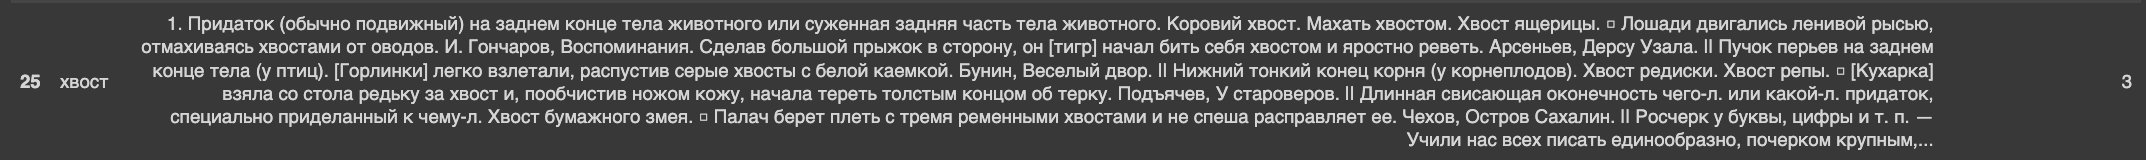  
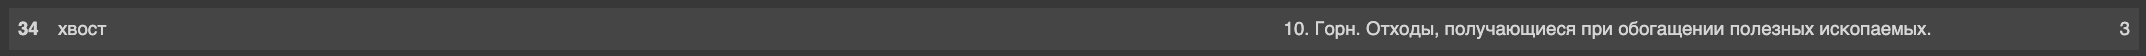


Еще одна проблема с золотым стандартом по значениям заключается в том, что некоторым словарным статьям приписывается один лейбл (см. пример с *хвостом* выше). Когда мы в нашей постановке задачи пытаемся выбрать 2-3 значения (рандомно, я следила за тем, чтобы выбрать значения с разными лейблами), в нашу выборку может попасть не прототипическое значение. Так в датасете ELMo у меня отобралось очень специальное значение для горнодобывающей промышленности, которое, естественно, ни разу не встречается в моем корпусе. Если бы рандомно мне выпало более прототипическое значение, метрика была бы выше. Поинт в том, что непонятно, как разделять словарные статьи с одним лейблом.

**Возможное решение** -- для значений попарно считать расстояние (например, косинусную близость) в adjacency matrix, например, **если значения похожи**:


*   и имеют одинаковый лейбл --> слить их в одно значение
*   и имеют разные лейблы --> присвоить второму лейбл первого и слить  

**Если значени не похожи**:
*   и имеют одинаковый лейбл --> присвоить одному из них лейбл наиболее с ним похожего
*   и имеют разные лейблы --> ничего не делать
И повторять эту процедуру пока мы не получим, что для всех похожих у нас будет мальенькое расстояние, для всех непохожих большое.  

**Сложности** -- непонятно, какой порог выбрать для схожести, может быть вычислительно сложно (хотя сами матрицы будут небольшими -- 10*10, если у слова 10 значений -- матриц может быть много)

**Еще одно решение** -- просто аккуратнее выбирать значения, совсем специальные отбрасывать, более современные, которых нет в словарях добавлять (в словаре Ефремовой для *карты* нет значеня 'банковская карта', которое в корпусе встречается часто).

**Если создать частично ручной золтой стандарт с четкими лейблами, можно будет использовать задачу классификации, что дает лучшие [результаты](sciendo.com/downloadpdf/journals/cait/20/4/article-p90.xml)**.


### Почему AdaGramm справляется лучше, чем ELMo + AffinityPropagation?


1.   Так как лейблы выбирались рандомно, для AdaGramm могли выбраться просто более прототипические леблы (но я думаю, что дело не в этом, так как в обоих финальных датасетах встречаются не очень прототипические слова равной мере)
2.   Кластеризатор внутри AdaGramm-а имел сильно бОльшую тренировочную выборку;
